# Milestone Project: SKIMLIT

In the previous notebook (NLP fundamentals in TensorFlow), we went through some fundamental natural lanuage processing concepts. The main ones being tokenzation (turning words into numbers) and creating embeddings (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

**Resurces**:
 * https://arxiv.org/abs/1710.06071

* https://arxiv.org/abs/1612.05251

## Get data
Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


* train.txt - training samples.
* dev.txt - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* test.txt - test samples.

In [3]:
# Start our experoments using the 20k dataset with numbers replaced by "@"
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Okay, now we've downloaded some text data, do you think we're ready to model it?

Wait...

We've downloaded the data but we haven't even looked at it yet.

What's the motto for getting familiar with any new dataset?

I'll give you a clue, the word begins with "v" and we say it three times.

Vibe, vibe, vibe?

Sort of... we've definitely got to the feel the vibe of our data.

Values, values, values?

Right again, we want to see lots of values but not quite what we're looking for.

Visualize, visualize, visualize?

Boom! That's it. To get familiar and understand how we have to prepare our data for our deep learning models, we've got to visualize it.

Because our data is in the form of text files, let's write some code to read each of the lines in a target file.

In [5]:
# Create a function to read the lines of a document
def get_lines(filename):
 """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
 """
 with open(filename, "r") as f:
    return f.readlines() # this reads the remaining lines from the file object and return them as a list


Alright, we've got a little function, get_lines() which takes the filepath of a text file, opens it, reads each of the lines and returns them.

Let's try it out on the training data (train.txt).

In [6]:
# Let's read in  the training line
train_lines = get_lines(data_dir + "/train.txt") # Read the lines with the training dile
train_lines[:20] # the first 20 lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.


The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).


Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).


Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.


Let's write a function to perform the following steps:


* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:
* * If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
Keep count of the number of lines in a sample.

* * If the line begins with \n mark it as the end of an abstract sample.
Keep count of the total lines in a sample.

* * Record the text before the \t as the label of the line.

* * Record the text after the \t as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
* * "line_number" - the position of the line in the abstract (e.g. 3).
* * "target" - the role of the line in the abstract (e.g. OBJECTIVE).
* * "text" - the text of the line in the abstract.
* * "total_lines" - the total lines in an abstract sample (e.g. 14).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):


[{  'line_number': 0,

  'target': 'OBJECTIVE',
    
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',

  'total_lines': 11,  ...}]

In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 748 ms, sys: 135 ms, total: 883 ms
Wall time: 1.97 s


(180040, 30212, 30135)

In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

How about we turn our list of dictionaries into pandas DataFrame's so we visualize them better?



In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

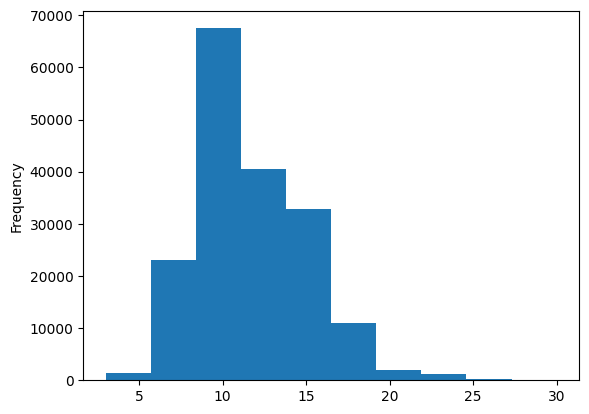

In [13]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1 , 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1 , 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1 , 1))
# Check what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from labelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modeling experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in Neural networks for joint sentence classification in medical paper abstracts.

For each model, we'll train it on the training data and evaluate it on the validation data.

## Model 0: Getting a baseline

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf" , TfidfVectorizer()),
    ("clf" , MultinomialNB())
])
# Fit the pipline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate basline model on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using our basline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])


To evaluate our baseline's predictions, we'll import the calculate_results() function we created in the previous notebook and added it to our helper_functions.py script to compare them to the ground truth labels.

More specificially the calculate_results() function will help us obtain the following:

* Accuracy
* Precision
* Recall
* F1-score

### Download helper functions script


In [22]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-15 21:02:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-15 21:02:15 (61.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import *

In [24]:
# claculate baseline result
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Preparing our data for deep sequence models

Excellent! We've got a working baseline to try and improve upon.

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).


Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

Let's write some code to find the average length of sentences in the training set.

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# How long is each sentences on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

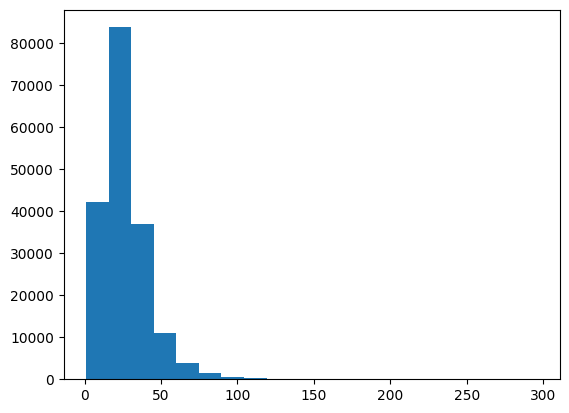

In [27]:
# What is the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens , bins=20);

In [28]:
# How long of a sentence length covers 95% of example
output_seq_len = int(np.percentile(sent_lens , 95))
output_seq_len

55

In [29]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Creating text vectorizer layer

Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the TextVectorization layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [30]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf )
max_tokens = 68000

In [31]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [32]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
therefore , the primary purpose of this trial is to identify the effects of reduced kams on knee oa pain and function .

Length of text: 23

Vectorized text:
[[  709     2    56   695     4    23    32    20     6   715     2    71
      4   191 20329    18   517  1743    65     3   149     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [34]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

###Create custom text embedding

Our token_vectorization layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's Embedding layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our Embedding layer.

The input_dim parameter defines the size of our vocabulary. And the output_dim parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our text_vectorization layer as inputs and convert them to feature vectors of size output_dim.

Let's see it in action.

In [36]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128,# Note: different embedding sizes result in drastically different numbers of parameters to train
                                # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

In [37]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
therefore , the primary purpose of this trial is to identify the effects of reduced kams on knee oa pain and function .

Sentence after vectorization (before embedding):
[[  709     2    56   695     4    23    32    20     6   715     2    71
      4   191 20329    18   517  1743    65     3   149     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01706685 -0.00538377 -0.04509246 ... -0.04497926  0.01574675
    0.01206816]
  [ 0.00875287 -0.04526131  0.04350739 ... -0.04102771 -0.01832681
   -0.03037633]
  [ 0.03656686  0.00564681  0.03457529 ...  0.02216724 -0.01406866
   -0.00076497]
  ...
  [ 0.0370024  -0.01535282  0.02614972 ... -0.00253607 -0.01359286
    0.04572095]
  [ 0.0370024  -0.01535282  0.02614972 ... -0.00253607 -0.01359286
    0.04572095]
  [ 0.037

## Creating datasets (making sure our data loads as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the tf.data API provides methods which enable faster data loading.

📖 Resource: For best practices on data loading in TensorFlow, check out the following:

* https://www.tensorflow.org/guide/data
* https://www.tensorflow.org/guide/data_performance


The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [38]:
# Turn our data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_one_hot))

In [39]:
# Take the TensorSliceDataset's and turn them into prefeched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTOTUNE will automaticlly prefetch as many sample as it can
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# In NLP project we do not need to shuffle the data because we need the order of the data

## Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

* Build model
* Train model
* Evaluate model (make predictions and compare to ground truth)

In [40]:
# Create 1D Conv model to process Sequences
inputs = layers.Input(shape=(1,) , dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64 , kernel_size = 5 , padding="same" , activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vecto
outputs = layers.Dense(5 , activation="softmax")(x)
model_1 = tf.keras.Model(inputs , outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

Wonderful! We've got our first deep sequence model built and ready to go.

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

**🔑 Note:** It's a standard practice in machine learning to test your models on smaller subsets of data first to make sure they work before scaling them to larger amounts of data. You should aim to run many smaller experiments rather than only a handful of large experiments. And since your time is limited, one of the best ways to run smaller experiments is to reduce the amount of data you're working with (10% of the full dataset is usually a good amount, as long as it covers a similar distribution).

In [42]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 21s 32ms/step - loss: 0.9068 - accuracy: 0.6429 - val_loss: 0.6872 - val_accuracy: 0.7314
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6635 - accuracy: 0.7506 - val_loss: 0.6428 - val_accuracy: 0.7660
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6250 - accuracy: 0.7683 - val_loss: 0.6048 - val_accuracy: 0.7809


In [43]:
# Evaluate model_1
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6063 - accuracy: 0.7832


[0.6063381433486938, 0.7831656336784363]

In [44]:
# MAke predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 4s 3ms/step


array([[4.2606249e-01, 1.8588956e-01, 6.4008497e-02, 3.0027178e-01,
        2.3767682e-02],
       [4.1647536e-01, 3.2272434e-01, 1.4317647e-02, 2.3722228e-01,
        9.2604291e-03],
       [1.9769913e-01, 7.8258039e-03, 2.3895013e-03, 7.9205936e-01,
        2.6172727e-05],
       ...,
       [1.0945862e-05, 7.2259852e-04, 1.2344497e-03, 5.0063559e-06,
        9.9802703e-01],
       [5.0238445e-02, 4.6181896e-01, 8.2267769e-02, 5.3599708e-02,
        3.5207507e-01],
       [1.5158539e-01, 6.9278949e-01, 3.7997816e-02, 6.0979377e-02,
        5.6647971e-02]], dtype=float32)

In [45]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate model results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.31656295511718,
 'precision': 0.7803329383655792,
 'recall': 0.7831656295511717,
 'f1': 0.7805342739705906}

##Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

**🔑 Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save using pretrained GloVe embeddings as an extension.

The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, feature extraction transfer learning. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

The feature extractor model we're building using a pretrained embedding from TensorFlow Hub.

To download the pretrained USE into a layer we can use in our model, we can use the hub.KerasLayer class.

We'll keep the pretrained embeddings frozen (by setting trainable=False) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

**🔑 Note:** Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [47]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

Beautiful, now our pretrained USE is downloaded and instantiated as a hub.KerasLayer instance, let's test it out on a random sentence.



In [48]:
# Test out the pretrained embedding on random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence}")
print(f"Length of sentence embedding:\n {len(use_embedded_sentence[0])}")

Random sentence:
 intervention patients participated in a @-week eat protocol consisting of @ hours of activity per week .
Sentence after embedding:
 [[-0.03680037  0.01722644 -0.00655158  0.032054   -0.0614755   0.03236059
   0.02566721 -0.03602055 -0.02724049  0.07282297  0.08733289 -0.00784154
  -0.03275082 -0.05489121 -0.08004858  0.03451152 -0.08999299 -0.00799669
  -0.04103772 -0.02305564 -0.02857033  0.04223203  0.0129416  -0.0179125
  -0.02165269  0.05418517 -0.06930168 -0.05498096 -0.05261759 -0.00244229
   0.02676201  0.093676   -0.02350399 -0.05496752 -0.0511062   0.02863097
  -0.02744406 -0.0917395   0.02917863 -0.07695416 -0.04276577  0.09133653
   0.03113716  0.03917184  0.05480756  0.03038373 -0.03913707 -0.03165927
  -0.00608105 -0.03498875 -0.01454796 -0.02123469  0.02181538  0.01071822
   0.07176992 -0.01338915  0.02225817 -0.02838704  0.08125135  0.02828439
  -0.05256342  0.05620892  0.0038634   0.01145253 -0.05279224  0.02720696
   0.0382776  -0.05459199  0.00223625

###Building and fitting an NLP feature extraction model from TensorFlow Hub


In [49]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding for each sequence (512 long vector)
x = layers.Dense(128 , activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding layer
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5 , activation="softmax")(x) # Create the output layer
model_2 = tf.keras.Model(inputs , outputs , name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [51]:
# Fit model_2 to the data
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 13ms/step - loss: 0.9159 - accuracy: 0.6470 - val_loss: 0.8002 - val_accuracy: 0.6852
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7718 - accuracy: 0.6998 - val_loss: 0.7593 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7567 - accuracy: 0.7100 - val_loss: 0.7453 - val_accuracy: 0.7128


In [52]:
# Evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7457 - accuracy: 0.7124


[0.7457239627838135, 0.7124321460723877]

In [53]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[4.7000632e-01, 3.2608607e-01, 2.5848497e-03, 1.9334327e-01,
        7.9794377e-03],
       [3.7910539e-01, 4.5014033e-01, 3.9074775e-03, 1.6333617e-01,
        3.5106142e-03],
       [2.2576599e-01, 1.5269141e-01, 1.7483782e-02, 5.5981869e-01,
        4.4240095e-02],
       ...,
       [1.6991196e-03, 4.8908121e-03, 5.7985734e-02, 8.6916640e-04,
        9.3455511e-01],
       [3.7501822e-03, 4.6897762e-02, 2.1112031e-01, 1.3236045e-03,
        7.3690808e-01],
       [1.6930115e-01, 2.3881947e-01, 5.2197170e-01, 6.3191289e-03,
        6.3588575e-02]], dtype=float32)

In [54]:
# Convert the predictions probs with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs ,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [55]:
# Calculate the results
model_2_results = calculate_results(val_labels_encoded , model_2_preds)
model_2_results

{'accuracy': 71.2432146167086,
 'precision': 0.7121640239139082,
 'recall': 0.712432146167086,
 'f1': 0.7096736948031042}

##Model 3: Conv1D with character embeddings

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

### Create a character-level tokenizer

In [56]:
# Make function to split sentence into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'i n t e r v e n t i o n   p a t i e n t s   p a r t i c i p a t e d   i n   a   @ - w e e k   e a t   p r o t o c o l   c o n s i s t i n g   o f   @   h o u r s   o f   a c t i v i t y   p e r   w e e k   .'

In [57]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [58]:
# What is the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

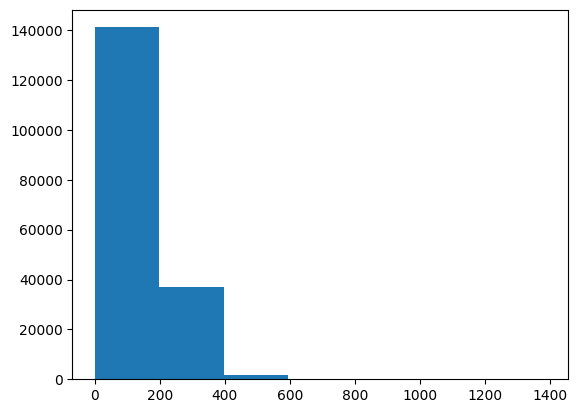

In [59]:
# check the distrubution of our sequence
plt.hist(char_lens ,bins=7);

In [60]:
# Find what character length covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

Wonderful, now we know the sequence length which covers 95% of sequences, we'll use that in our TextVectorization layer as the output_sequence_length parameter.

**🔑 Note:** You can experiment here to figure out what the optimal output_sequence_length should be, perhaps using the mean results in as good results as using the 95% percentile.

We'll set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [61]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space + OOV (OOV = out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer",
                                    standardize="lower_and_strip_punctuation")


Nice! Now we've adapted our char_vectorizer to our character-level sequences, let's check out some characteristics about it using the get_vocabulary() method.

In [63]:
# Adapt char-vectorizer to training character
char_vectorizer.adapt(train_chars)

In [64]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [65]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
c n p   r e m a i n s   r e l a t i v e l y   c o m m o n   a f t e r   c e a   ,   b u t   i s   r a r e l y   d i s a b l i n g   .

Length of chars: 56

Vectorized chars:
[[11  6 14  8  2 15  5  4  6  9  8  2 12  5  3  4 21  2 12 19 11  7 15 15
   7  6  5 17  3  2  8 11  2  5 22 16  3  4  9  8  5  8  2 12 19 10  4  9
   5 22 12  4  6 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0


You'll notice sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.

**🔑 Note:** If you didn't want punctuation to be removed (keep the @, % etc), you can create a custom standardization callable and pass it as the standardize parameter. See the TextVectorization layer documentation for more.

## Creating a character-level embedding

In [66]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS, # number of different characters
                              output_dim = 25,
                              mask_zero=True,
                              name="char_embed")

In [67]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
c n p   r e m a i n s   r e l a t i v e l y   c o m m o n   a f t e r   c e a   ,   b u t   i s   r a r e l y   d i s a b l i n g   .

Embedded chars (after vectorization and embedding):
[[[ 0.04568753  0.03383033 -0.02024697 ... -0.01637726  0.00808366
   -0.03336741]
  [ 0.00655865 -0.02349134 -0.03463191 ...  0.04896731 -0.02687007
    0.04502753]
  [ 0.02964647  0.00089259 -0.03669505 ...  0.02336098 -0.0239787
   -0.02350699]
  ...
  [-0.03777678  0.02033707  0.03767389 ...  0.02351273  0.03506433
   -0.0181772 ]
  [-0.03777678  0.02033707  0.03767389 ...  0.02351273  0.03506433
   -0.0181772 ]
  [-0.03777678  0.02033707  0.03767389 ...  0.02351273  0.03506433
   -0.0181772 ]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [68]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,) , dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64 , kernel_size=5 , padding="same" , activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5 , activation="softmax")(x)
model_3 = tf.keras.Model(inputs , outputs , name="model_3_conv1d_char_embeddings")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [70]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars , train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars , test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [71]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2551 - accuracy: 0.4924 - val_loss: 1.0462 - val_accuracy: 0.5894
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0158 - accuracy: 0.5922 - val_loss: 0.9502 - val_accuracy: 0.6243
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9354 - accuracy: 0.6322 - val_loss: 0.8751 - val_accuracy: 0.6602


In [72]:
# Evaluate the model
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8958 - accuracy: 0.6517


[0.8957732915878296, 0.6516615748405457]

In [73]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.17520964, 0.4821524 , 0.09865348, 0.20662153, 0.037363  ],
       [0.2249369 , 0.36591712, 0.01030644, 0.35791707, 0.04092241],
       [0.11650456, 0.08028985, 0.34689033, 0.39908618, 0.05722906],
       ...,
       [0.01515998, 0.05656214, 0.2372917 , 0.03868863, 0.65229756],
       [0.05078475, 0.11588407, 0.2738704 , 0.03677886, 0.52268195],
       [0.26021135, 0.4949871 , 0.1204759 , 0.11057249, 0.01375318]],
      dtype=float32)

In [74]:
# Convert the predictions into labels
model_3_preds = tf.argmax(model_3_pred_probs , axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [75]:
# Get the results
model_3_results = calculate_results(val_labels_encoded , model_3_preds)
model_3_results

{'accuracy': 65.16615914206275,
 'precision': 0.6503341077254504,
 'recall': 0.6516615914206275,
 'f1': 0.6385209437348572}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Alright, now things are going to get spicy.

In moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using layers.Concatenate) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [76]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[] , dtype=tf.string , name="token_input")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128 , activation="relu")(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup cahr inputs/model
char_inputs = layers.Input(shape=(1,) ,dtype=tf.string , name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of Neural Networks for Joint Sentence Classification
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding Dropout , discussed in the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combuned_dense = layers.Dense(128 , activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combuned_dense)
output_layer = layers.Dense(5 , activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input , char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [77]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

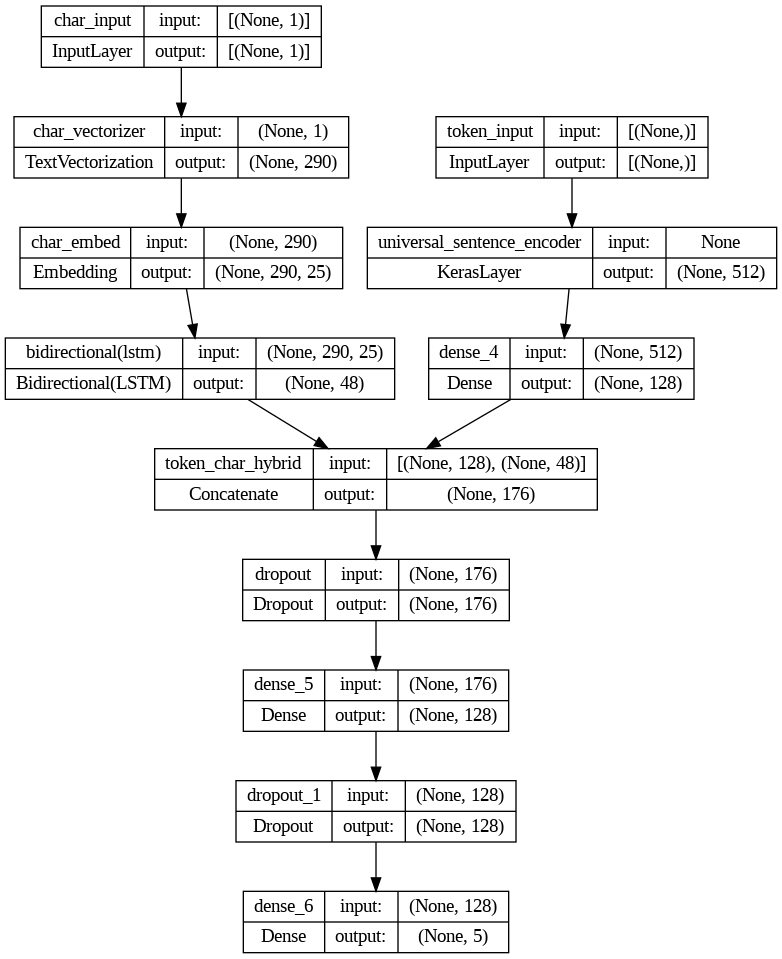

In [78]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4 , show_shapes=True)

In [79]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token  and character data into a tf.data Dataset

In [80]:
# Combine chars and tokens into dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data , train_char_token_labels)) # Combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
# Check out our training char and token embedding dataset
train_char_token_dataset , val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [83]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 47s 61ms/step - loss: 0.9825 - accuracy: 0.6058 - val_loss: 0.7915 - val_accuracy: 0.6978
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.8029 - accuracy: 0.6904 - val_loss: 0.7187 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 26s 47ms/step - loss: 0.7737 - accuracy: 0.7030 - val_loss: 0.6942 - val_accuracy: 0.7350


In [84]:
# Evaluate the model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6991 - accuracy: 0.7332


[0.6990744471549988, 0.7332186102867126]

In [85]:
# model_4 perdictions probs
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 22s 20ms/step


array([[4.5141900e-01, 3.1131434e-01, 3.3856407e-03, 2.2855692e-01,
        5.3241160e-03],
       [3.3137181e-01, 4.5859486e-01, 4.2228862e-03, 2.0392041e-01,
        1.8899790e-03],
       [2.5715101e-01, 1.4483729e-01, 4.9066089e-02, 5.1252514e-01,
        3.6420513e-02],
       ...,
       [7.6402753e-04, 7.1053398e-03, 6.9088079e-02, 2.2605070e-04,
        9.2281651e-01],
       [7.7072275e-03, 6.3177571e-02, 1.8659276e-01, 3.8060800e-03,
        7.3871642e-01],
       [3.0434734e-01, 3.4577760e-01, 3.0442744e-01, 1.2072875e-02,
        3.3374771e-02]], dtype=float32)

In [86]:
# Convert prediction into label
model_4_preds = tf.argmax(model_4_pred_probs , axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [87]:
# Calculate results
model_4_results = calculate_results(val_labels_encoded , model_4_preds)
model_4_results

{'accuracy': 73.32185886402753,
 'precision': 0.7334804111091031,
 'recall': 0.7332185886402753,
 'f1': 0.730031635469863}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings


It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled CONCLUSIONS at the beggining and sequences labelled OBJECTIVE at the end?

Abstracts typically come in a sequential order, such as:

* OBJECTIVE ...
* METHODS ...
* METHODS ...
* METHODS ...
* RESULTS ...
* CONCLUSIONS ...

Or

* BACKGROUND ...
* OBJECTIVE ...
* METHODS ...
* METHODS ...
* RESULTS ...
* RESULTS ...
* CONCLUSIONS ...
* CONCLUSIONS ...

Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

* Sentence 1 of 10 ...
* Sentence 2 of 10 ...
* Sentence 3 of 10 ...
* Sentence 4 of 10 ...
* ...

You might've noticed this when we created our preprocess_text_with_line_numbers() function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the "line_number" and "total_lines" columns of our DataFrames.

### Create positonal embedding

The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time.

In [88]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

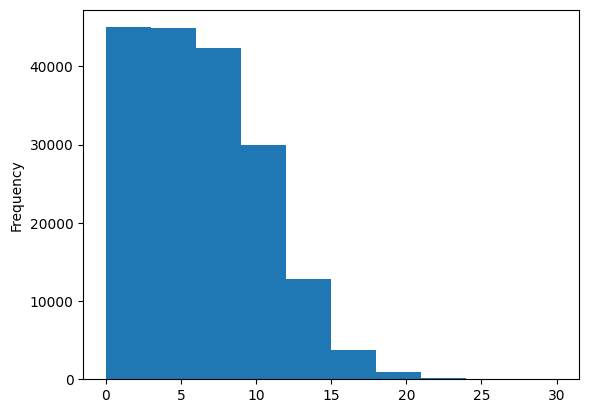

In [89]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [90]:
# Use tensorflow to create one-hot-encoded tensors of our "line_numbers" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy() , depth=15)

Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

**🔑 Note:** We could create a one-hot tensor which has room for all of the potential values of "line_number" (depth=30), however, this would end up in a tensor of double the size of our current one (depth=15) where the vast majority of values are 0. Plus, only ~2,000/180,000 samples have a "line_number" value of over 15. So we would not be gaining much information about our data for doubling our feature space. This kind of problem is called the curse of dimensionality. However, since this we're working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I'll leave exploring values of the depth parameter as an extension.

In [91]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:10]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

We can do the same as we've done for our "line_number" column witht he "total_lines" column. First, let's find an appropriate value for the depth parameter of tf.one_hot.

In [92]:
# How many different numbers of lines there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

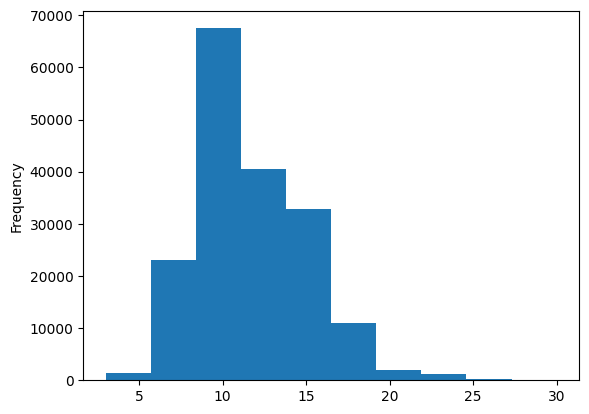

In [93]:
# Check the distribution of totel line
train_df.total_lines.plot.hist();

Looking at the distribution of our "total_lines" column, a value of 20 looks like it covers the majority of samples.

We can confirm this with np.percentile().

In [94]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines , 98)

20.0


Beautiful! Plenty of converage. Let's one-hot-encode our "total_lines" column just as we did our "line_number" column.

In [95]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" features
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy() , depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building a tribrid embedding model

It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

We'll be venturing into uncovered territory but there will be nothing here you haven't practiced before.

More specifically we're going to go through the following steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model
Woah! That's alot... but nothing we're not capable of. Let's code it.

In [109]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [110]:
model_5.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

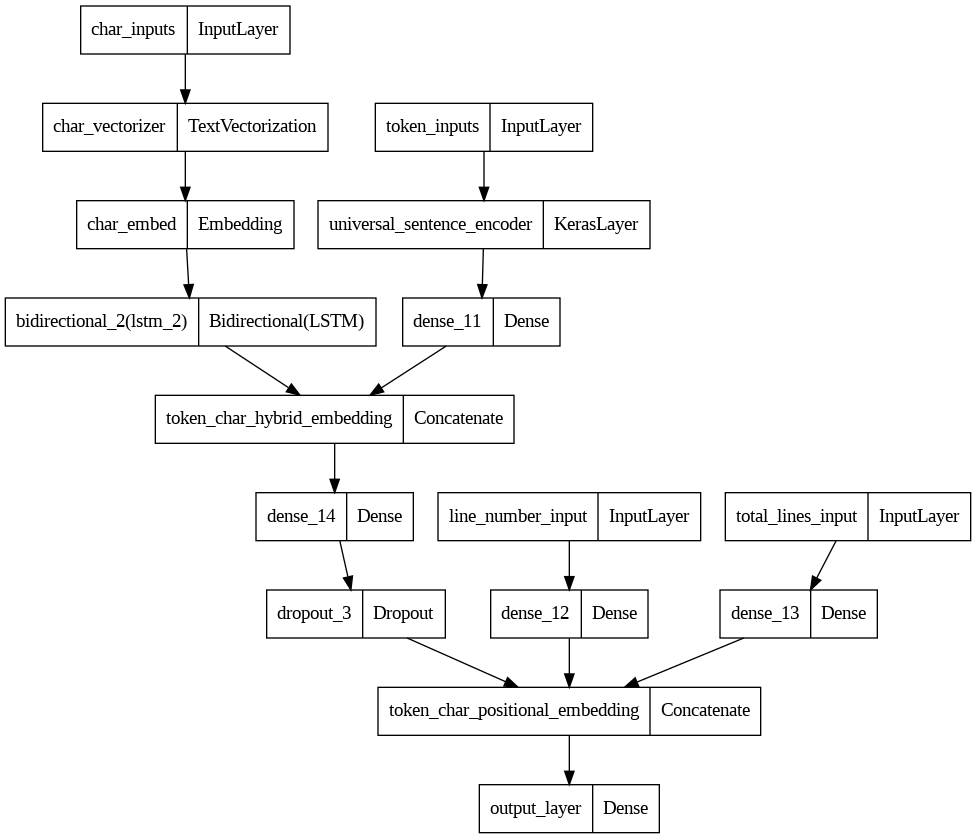

In [111]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [112]:
# Compile token , char , and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

This time, we're going to introduce a new parameter to our loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

[0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
It's predictions will get smoothed to be something like:

[0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.
**📖 Resource:** For more on label smoothing, see the great blog post by PyImageSearch, https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

### Create tribrid embedding datasets and fit tribrid model

Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

* Train line numbers one-hot tensor (train_line_numbers_one_hot)
* Train total lines one-hot tensor (train_total_lines_one_hot)
* Token-level sequences tensor (train_sentences)
* Char-level sequences tensor (train_chars)
We can pass these as tuples to our tf.data.Dataset.from_tensor_slices() method to create appropriately shaped and batched PrefetchedDataset's.

In [113]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [114]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 48s 59ms/step - loss: 1.0947 - accuracy: 0.7279 - val_loss: 0.9810 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9648 - accuracy: 0.8171 - val_loss: 0.9457 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9481 - accuracy: 0.8232 - val_loss: 0.9354 - val_accuracy: 0.8324


In [115]:
# evaluate with the char token pos model
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 35s 37ms/step - loss: 0.9345 - accuracy: 0.8346


[0.9345164895057678, 0.8345690369606018]

In [116]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 39s 37ms/step


array([[0.50754124, 0.10284076, 0.01263788, 0.3607195 , 0.01626058],
       [0.5210874 , 0.09188896, 0.04087636, 0.3331928 , 0.01295441],
       [0.30037874, 0.12078241, 0.13496156, 0.3756094 , 0.06826783],
       ...,
       [0.03548732, 0.10908813, 0.04602918, 0.03234805, 0.77704734],
       [0.03841811, 0.30530816, 0.08309439, 0.02881478, 0.5443646 ],
       [0.17780547, 0.5754666 , 0.13301648, 0.04026976, 0.07344174]],
      dtype=float32)

In [119]:
# Convert predictions into labels
model_5_preds = tf.argmax(model_5_pred_probs , axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [120]:
# Calculate the results
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.4569045412419,
 'precision': 0.8334097128414004,
 'recall': 0.8345690454124189,
 'f1': 0.833582483602409}

# Additions

In [121]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.316563,0.780333,0.783166,0.780534
pretrained_token_embed,71.243215,0.712164,0.712432,0.709674
custom_char_embed_conv1d,65.166159,0.650334,0.651662,0.638521
hybrid_char_token_embed,73.321859,0.733480,0.733219,0.730032
tribrid_pos_char_token_embed,83.456905,0.833410,0.834569,0.833582


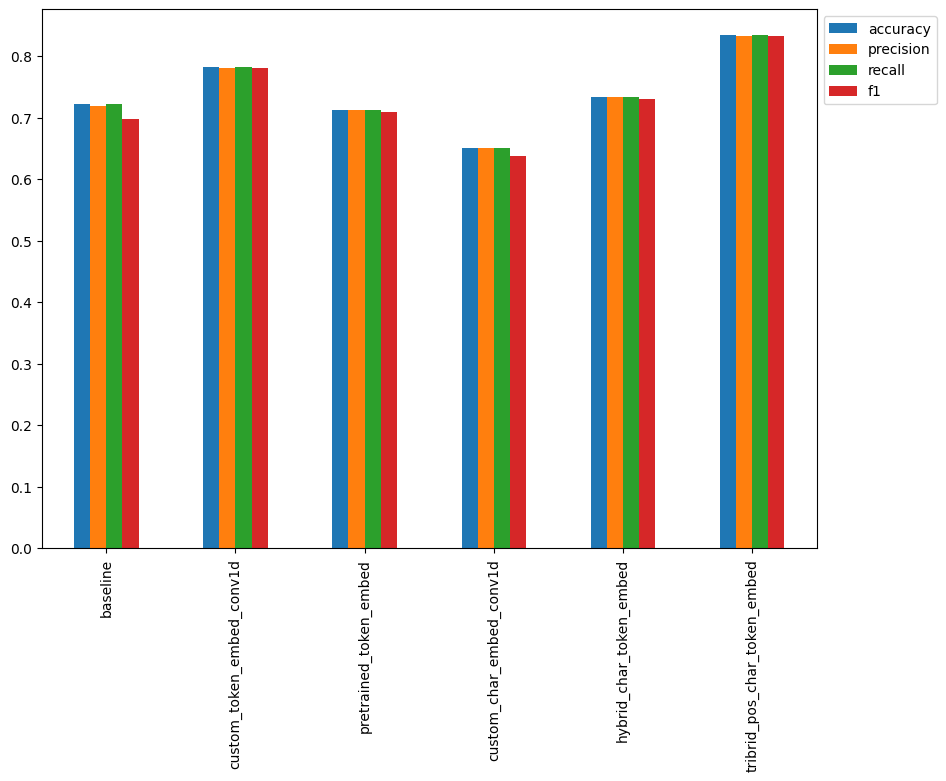

In [122]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

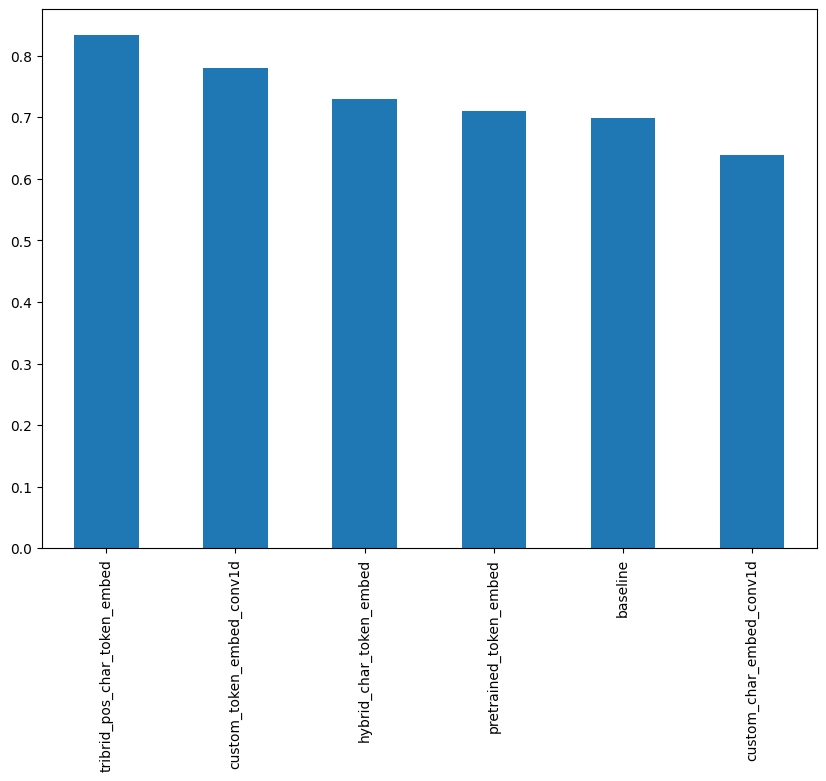

In [123]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));